# Introduction

This is the WSDM - KKBox’s Churn Prediction Challenge with Python.

The aim of this challenge is to predict whether a user of the music streaming service KKBox will “churn”, i.e. leave this subscription-based service, by analysing the user’s behaviour on the website.

The data comes in the shape of five different files. Four of them contain the user IDs and properties:

- In train.csv we find the IDs and whether these users have churned or not.

- transactions.csv gives us details like payment method or whether the subscription was cancelled.

- user_logs.csv contains the listening behaviour of a user in terms of number of songs played.

- members.csv includes the user’s age, city, and such for users that have these membership information.

Finally, sample_submission_zero.csv serves as the test data set for the users for which we are tasked to predict their behaviour. Some of these files are large, with a maximum of about 6.65 GB for the user_logs data in a compressed form. We will discuss more of their content and features as the exploration goes along.



1. [Load library](#1)
1. [Load data](#2)
1. [File structure and content](#3)
1. [Data exploration](#4)
 - City, registered_via and Gender
 - registration_init_time 
 - bd (age)
 - payment_method_id count
 - payment_method_id count
 - payment_plan_days count
 - plan_list_price count
 - actual_amount_paid count
 - is_auto_renew count
 - is_cancel count

1. [Data processing](#5)
1. [Models Selection](#6)
1. [Oversampling methods](#7)
 - RandomOverSampler
 - SMOTE
 - Adasyn
 
1. [Hyperparameters tuning](#8)
1. [First submit to Kaggle](#9)
1. [Feature Engineering](#10)
 - Feature 1 : discount
 - Feature 2 : is_discount
 - Feature 3 : amount_per_day
 - Feature 4 : membership_duration
 - Feature 5 : autorenew_&_not_cancel
 - Feature 6 : notAutorenew_&_cancel
 
1. [Model selection](#11)
1. [Second submit to Kaggle](#12)

<a id="1"></a> <br>
## Load library

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime
from collections import Counter

<a id="2"></a> <br>
## Load data

In [2]:
pd.set_option('display.max_rows', None)

train = pd.read_csv('train.csv')
#sample_submission_zero= pd.read_csv('../input/sample_submission_zero.csv')
members = pd.read_csv('members_v3.csv')
transactions = pd.read_csv('transactions.csv')
#user_logs = pd.read_csv('../input/user_logs.csv',nrows = 2e7)

<a id="3"></a> <br>
## File structure and content

Let's explore our train data set :

In [5]:
train.head()

,msno,is_churn
0,waLDQMmcOu2jLDaV1ddDkgCrB/jl6sD66Xzs0Vqax1Y=,1
1,QA7uiXy8vIbUSPOkCf9RwQ3FsT8jVq2OxDr8zqa7bRQ=,1
2,fGwBva6hikQmTJzrbz/2Ezjm5Cth5jZUNvXigKK2AFA=,1
3,mT5V8rEpa+8wuqi6x0DoVd3H5icMKkE9Prt49UlmK+4=,1
4,XaPhtGLk/5UvvOYHcONTwsnH97P4eGECeq+BARGItRw=,1


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 992931 entries, 0 to 992930
Data columns (total 2 columns):
msno        992931 non-null object
is_churn    992931 non-null int64
dtypes: int64(1), object(1)
memory usage: 15.2+ MB


In [8]:
train.describe()

,is_churn
count,992931.000000
mean,0.063923
std,0.244616
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


So train file contains 992931 user-ids(msno) with the binary classification as 1 (churn) and 0 ( no churn). Also the  training set majority users are in no churn category (0) - about 94 % and about 6% are accounting to churn. We have a very biased training set here, but that almost always the case in churn so no worries. We will deal with that.

Next I will merge training set with members data set to explore more into training data sets.

In [3]:
training = pd.merge(left = train,right = members,how = 'left',on=['msno'])
training.head()

,msno,is_churn,city,bd,gender,registered_via,registration_init_time
0,waLDQMmcOu2jLDaV1ddDkgCrB/jl6sD66Xzs0Vqax1Y=,1,18.0,36.0,female,9.0,20050406.0
1,QA7uiXy8vIbUSPOkCf9RwQ3FsT8jVq2OxDr8zqa7bRQ=,1,10.0,38.0,male,9.0,20050407.0
2,fGwBva6hikQmTJzrbz/2Ezjm5Cth5jZUNvXigKK2AFA=,1,11.0,27.0,female,9.0,20051016.0
3,mT5V8rEpa+8wuqi6x0DoVd3H5icMKkE9Prt49UlmK+4=,1,13.0,23.0,female,9.0,20051102.0
4,XaPhtGLk/5UvvOYHcONTwsnH97P4eGECeq+BARGItRw=,1,3.0,27.0,male,9.0,20051228.0


In [10]:
training.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 992931 entries, 0 to 992930
Data columns (total 7 columns):
msno                      992931 non-null object
is_churn                  992931 non-null int64
city                      877161 non-null float64
bd                        877161 non-null float64
gender                    391692 non-null object
registered_via            877161 non-null float64
registration_init_time    877161 non-null float64
dtypes: float64(4), int64(1), object(2)
memory usage: 60.6+ MB


We see that in the new merged data sets, the maximum non-null entries apart from is_churn and msno is 876143 (City, bd, registered_via, registration_init_time, expiration_date). So there are 116788 entries which dosen't have any data ( about 12%). Also there is concern in gender columns as about 60% null entries.

Changing the format of city and registered_via( except missing values) from float to int and changing blank values with NAN( for city, registered_via and gender)

In [4]:
training['city'] = training.city.apply(lambda x: int(x) if pd.notnull(x) else "NAN")
training['registered_via'] = training.registered_via.apply(lambda x: int(x) if pd.notnull(x) else "NAN")
training['gender']=training['gender'].fillna("NAN")
training.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 992931 entries, 0 to 992930
Data columns (total 7 columns):
msno                      992931 non-null object
is_churn                  992931 non-null int64
city                      992931 non-null object
bd                        877161 non-null float64
gender                    992931 non-null object
registered_via            992931 non-null object
registration_init_time    877161 non-null float64
dtypes: float64(2), int64(1), object(4)
memory usage: 60.6+ MB


Changing the format of dates in YYYY-MM-DD

In [5]:
training['registration_init_time'] = training.registration_init_time.apply(lambda x: datetime.strptime(str(int(x)), "%Y%m%d").date() if pd.notnull(x) else "NAN" )
#training['expiration_date'] = training.expiration_date.apply(lambda x: datetime.strptime(str(int(x)), "%Y%m%d").date() if pd.notnull(x) else "NAN")
training.head()

,msno,is_churn,city,bd,gender,registered_via,registration_init_time
0,waLDQMmcOu2jLDaV1ddDkgCrB/jl6sD66Xzs0Vqax1Y=,1,18,36.0,female,9,2005-04-06
1,QA7uiXy8vIbUSPOkCf9RwQ3FsT8jVq2OxDr8zqa7bRQ=,1,10,38.0,male,9,2005-04-07
2,fGwBva6hikQmTJzrbz/2Ezjm5Cth5jZUNvXigKK2AFA=,1,11,27.0,female,9,2005-10-16
3,mT5V8rEpa+8wuqi6x0DoVd3H5icMKkE9Prt49UlmK+4=,1,13,23.0,female,9,2005-11-02
4,XaPhtGLk/5UvvOYHcONTwsnH97P4eGECeq+BARGItRw=,1,3,27.0,male,9,2005-12-28


That's better !

<a id="4"></a> <br>
## Data Exploration

### City, registered_via and Gender

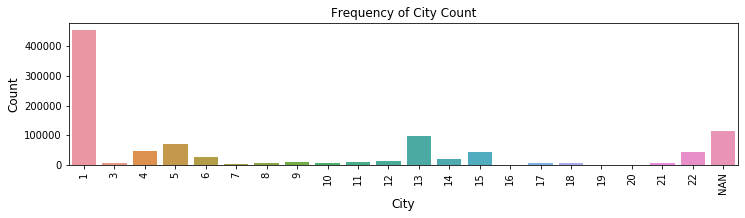

City Count [(1, 455389), ('NAN', 115770), (13, 98281), (5, 71299), (4, 47945), (15, 43356), (22, 42129), (6, 26022), (14, 20167), (12, 11554), (9, 9558), (11, 9036), (18, 7842), (8, 7690), (10, 6533), (17, 5546), (21, 5286), (3, 5089), (7, 2666), (16, 956), (20, 677), (19, 140)]


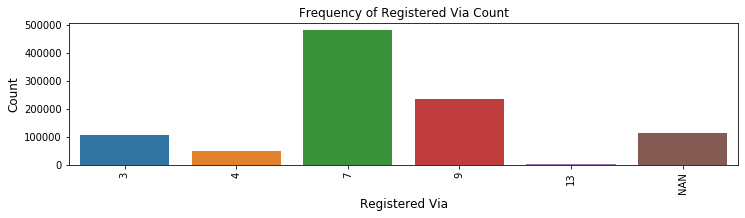

Registered Via Count [(7, 482726), (9, 236620), ('NAN', 115770), (3, 105445), (4, 49283), (13, 3087)]


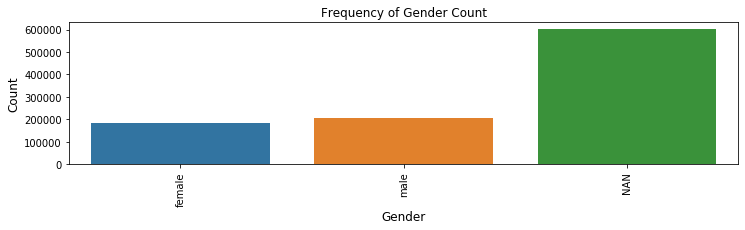

Gender Count [('NAN', 601239), ('male', 206284), ('female', 185408)]


In [15]:
# City count
plt.figure(figsize=(12,12))
plt.subplot(411)
city_order = training['city'].unique()
city_order=sorted(city_order, key=lambda x: float(x))
sns.countplot(x="city", data=training , order = city_order)
plt.ylabel('Count', fontsize=12)
plt.xlabel('City', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of City Count", fontsize=12)
plt.show()
city_count = Counter(training['city']).most_common()
print("City Count " +str(city_count))

#Registered Via Count
plt.figure(figsize=(12,12))
plt.subplot(412)
R_V_order = training['registered_via'].unique()
R_V_order = sorted(R_V_order, key=lambda x: str(x))
R_V_order = sorted(R_V_order, key=lambda x: float(x))
#above repetion of commands are very silly, but this was the only way I was able to diplay what I wanted
sns.countplot(x="registered_via", data=training,order = R_V_order)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Registered Via', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Registered Via Count", fontsize=12)
plt.show()
RV_count = Counter(training['registered_via']).most_common()
print("Registered Via Count " +str(RV_count))

#Gender count
plt.figure(figsize=(12,12))
plt.subplot(413)
sns.countplot(x="gender", data=training)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Gender', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Gender Count", fontsize=12)
plt.show()
gender_count = Counter(training['gender']).most_common()
print("Gender Count " +str(gender_count))


### registration_init_time Trends exploration

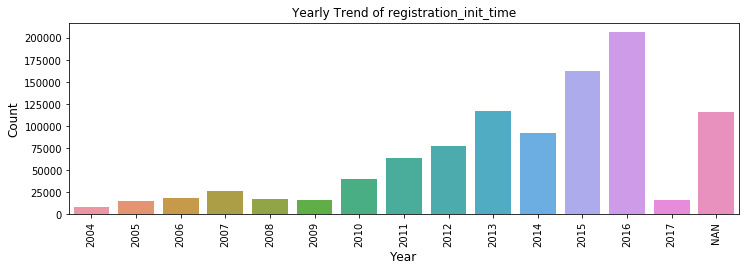

Yearly Count [(2016, 206892), (2015, 162008), (2013, 117059), ('NAN', 115770), (2014, 91680), (2012, 77280), (2011, 63379), (2010, 39906), (2007, 26355), (2006, 18193), (2008, 17725), (2017, 16691), (2009, 15804), (2005, 15759), (2004, 8430)]


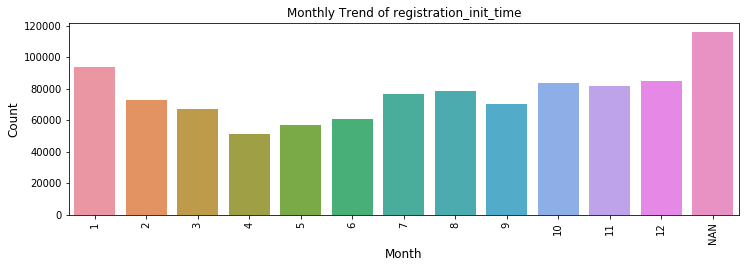

Monthly Count [('NAN', 115770), (1, 93707), (12, 84608), (10, 83335), (11, 81403), (8, 78424), (7, 76490), (2, 72651), (9, 70357), (3, 67086), (6, 60608), (5, 57224), (4, 51268)]


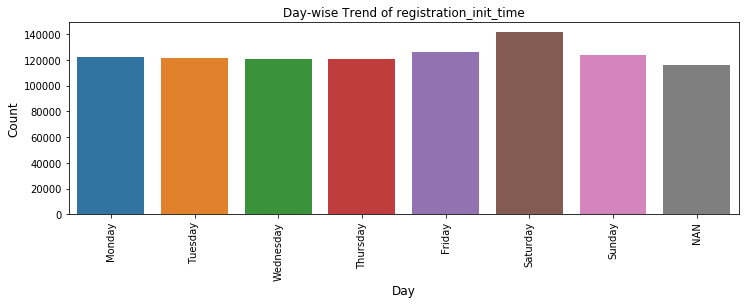

Day-wise Count [('Saturday', 141948), ('Friday', 126268), ('Sunday', 124120), ('Monday', 122189), ('Tuesday', 121536), ('Thursday', 120794), ('Wednesday', 120306), ('NAN', 115770)]


In [17]:
#registration_init_time yearly trend
training['registration_init_time_year'] = pd.DatetimeIndex(training['registration_init_time']).year
training['registration_init_time_year'] = training.registration_init_time_year.apply(lambda x: int(x) if pd.notnull(x) else "NAN" )
year_count=training['registration_init_time_year'].value_counts()
#print(year_count)
plt.figure(figsize=(12,12))
plt.subplot(311)
year_order = training['registration_init_time_year'].unique()
year_order=sorted(year_order, key=lambda x: str(x))
year_order = sorted(year_order, key=lambda x: float(x))
sns.barplot(year_count.index, year_count.values,order=year_order)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Yearly Trend of registration_init_time", fontsize=12)
plt.show()
year_count_2 = Counter(training['registration_init_time_year']).most_common()
print("Yearly Count " +str(year_count_2))

#registration_init_time monthly trend
training['registration_init_time_month'] = pd.DatetimeIndex(training['registration_init_time']).month
training['registration_init_time_month'] = training.registration_init_time_month.apply(lambda x: int(x) if pd.notnull(x) else "NAN" )
month_count=training['registration_init_time_month'].value_counts()
plt.figure(figsize=(12,12))
plt.subplot(312)
month_order = training['registration_init_time_month'].unique()
month_order = sorted(month_order, key=lambda x: str(x))
month_order = sorted(month_order, key=lambda x: float(x))
sns.barplot(month_count.index, month_count.values,order=month_order)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Month', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Monthly Trend of registration_init_time", fontsize=12)
plt.show()
month_count_2 = Counter(training['registration_init_time_month']).most_common()
print("Monthly Count " +str(month_count_2))

#registration_init_time day wise trend
training['registration_init_time_weekday'] = pd.DatetimeIndex(training['registration_init_time']).weekday_name
training['registration_init_time_weekday'] = training.registration_init_time_weekday.apply(lambda x: str(x) if pd.notnull(x) else "NAN" )
day_count=training['registration_init_time_weekday'].value_counts()
plt.figure(figsize=(12,12))
plt.subplot(313)
#day_order = training['registration_init_time_day'].unique()
day_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday','NAN']
sns.barplot(day_count.index, day_count.values,order=day_order)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Day', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Day-wise Trend of registration_init_time", fontsize=12)
plt.show()
day_count_2 = Counter(training['registration_init_time_weekday']).most_common()
print("Day-wise Count " +str(day_count_2))


Observations :

- There are total of 21 Cities Encoded ( there is no City "2" in the data set). This will be one-hot encoded.
- There are Class of "3", "4", "7", "9", "13" listed as registration method. This will be one-hot encoded.
- There are almost equal percentage of Male and Female, but about 60% of data is missing in gender field. We have see how to fill the missing entries or label them as third category. 
- Registration trend has increased yearly, though there was a dip in 2014. Due to data upto few months in 2017, there is a dip.
- Registration monthly trends are high in year end and year starting months. In between there is a smooth valley formation.
- Registration daily trends quite stable, maybe some peaks on weekends.

Now let's check our last variable : bd (birth daten correspond à l'age)

### bd (age)

In [18]:
bd_1=training.bd.value_counts()
bd_1.head()

0.0     487488
27.0     22950
26.0     22149
25.0     20870
28.0     20492
Name: bd, dtype: int64

In [6]:
training['bd'] = training.bd.apply(lambda x: int(x) if pd.notnull(x) else "NAN" )
bd_count = Counter(training['bd']).most_common()
print("BD Count " +str(bd_count))

BD Count [(0, 487488), ('NAN', 115770), (27, 22950), (26, 22149), (25, 20870), (28, 20492), (24, 20476), (29, 19778), (23, 19329), (22, 17960), (30, 17413), (21, 15564), (31, 15231), (32, 14652), (20, 13601), (33, 13492), (34, 12236), (35, 11175), (36, 10071), (19, 9639), (37, 9020), (18, 7937), (38, 7771), (39, 6720), (40, 5714), (17, 5605), (41, 5265), (42, 4412), (43, 3747), (44, 3312), (45, 3063), (46, 3010), (47, 2920), (48, 2571), (16, 2435), (49, 2372), (50, 2053), (51, 1994), (52, 1778), (53, 1471), (54, 1185), (55, 1019), (56, 851), (15, 794), (57, 744), (58, 548), (59, 519), (60, 454), (61, 395), (62, 319), (63, 262), (14, 234), (64, 197), (65, 169), (66, 155), (67, 139), (68, 86), (106, 80), (69, 73), (117, 67), (70, 60), (112, 54), (13, 51), (72, 45), (71, 38), (73, 38), (77, 31), (74, 29), (12, 25), (1, 25), (75, 22), (76, 22), (84, 20), (95, 19), (105, 18), (102, 18), (6, 17), (89, 16), (92, 16), (81, 16), (7, 15), (91, 15), (103, 15), (104, 14), (5, 14), (101, 13), (83, 

- First we can make all Birth date <= 1 to -99999( just a large -ve number) as I don't think it would make a difference
- Next we can also ignore the Birth Date >= 100.

In [7]:
training['bd'] = training.bd.apply(lambda x: -99999 if float(x)<=1 else x)
training['bd'] = training.bd.apply(lambda x: -99999 if float(x)>=100 else x)

In [8]:
bd_2=training.bd.value_counts()
bd_2.head()

-99999    488052
NAN       115770
27         22950
26         22149
25         20870
Name: bd, dtype: int64

That's it !

Mean of Birth Date = 29.97192303441966
Median of Birth Date = 28.0


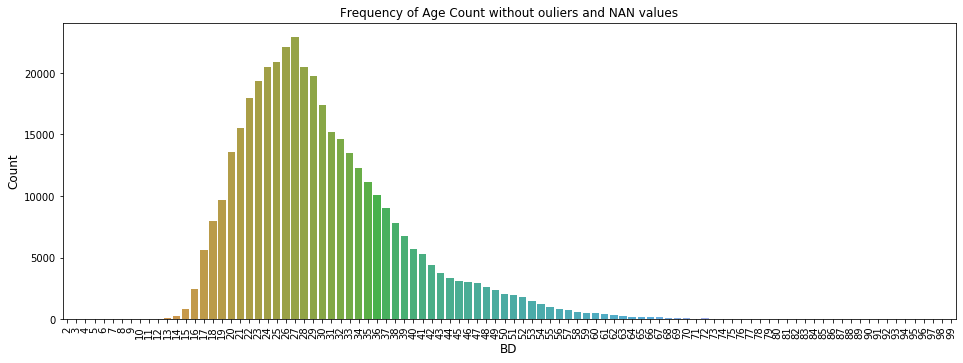

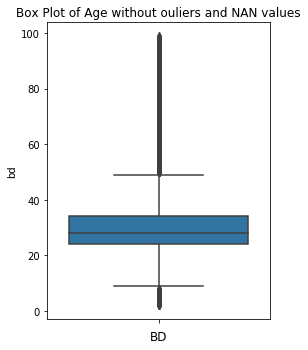

In [25]:
tmp_bd = training[(training.bd != "NAN") & (training.bd != -99999)]
print("Mean of Birth Date = " +str(np.mean(tmp_bd['bd'])))
print("Median of Birth Date = " +str(np.median(tmp_bd['bd'])))
#print("Mode of Birth Date = " +str(np.mode(tmp_bd['bd'])))
plt.figure(figsize=(16,12))
plt.subplot(211)
bd_order_2 = tmp_bd['bd'].unique()
bd_order_2 = sorted(bd_order_2, key=lambda x: float(x))
sns.countplot(x="bd", data=tmp_bd , order = bd_order_2)
plt.ylabel('Count', fontsize=12)
plt.xlabel('BD', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Age Count without ouliers and NAN values", fontsize=12)
plt.show()

plt.figure(figsize=(4,12))
plt.subplot(212)
sns.boxplot(y=tmp_bd["bd"],data=tmp_bd)
plt.xlabel('BD', fontsize=12)
plt.title("Box Plot of Age without ouliers and NAN values", fontsize=12)
plt.show()

So mostly we see that age is in-between 15-50 years mostly, excluding the outliers( about 49% ) and NA's(12%).

Now, let us explore transactions data set

In [26]:
transactions.head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,YyO+tlZtAXYXoZhNr3Vg3+dfVQvrBVGO8j1mfqe4ZHc=,41,30,129,129,1,20150930,20151101,0
1,AZtu6Wl0gPojrEQYB8Q3vBSmE2wnZ3hi1FbK1rQQ0A4=,41,30,149,149,1,20150930,20151031,0
2,UkDFI97Qb6+s2LWcijVVv4rMAsORbVDT2wNXF0aVbns=,41,30,129,129,1,20150930,20160427,0
3,M1C56ijxozNaGD0t2h68PnH2xtx5iO5iR2MVYQB6nBI=,39,30,149,149,1,20150930,20151128,0
4,yvj6zyBUaqdbUQSrKsrZ+xNDVM62knauSZJzakS9OW4=,39,30,149,149,1,20150930,20151121,0


In [27]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21547746 entries, 0 to 21547745
Data columns (total 9 columns):
msno                      object
payment_method_id         int64
payment_plan_days         int64
plan_list_price           int64
actual_amount_paid        int64
is_auto_renew             int64
transaction_date          int64
membership_expire_date    int64
is_cancel                 int64
dtypes: int64(8), object(1)
memory usage: 1.4+ GB


In [28]:
transactions.describe()

,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
count,2.154775e+07,2.154775e+07,2.154775e+07,2.154775e+07,2.154775e+07,2.154775e+07,2.154775e+07,2.154775e+07
mean,3.893310e+01,3.133906e+01,1.398850e+02,1.419873e+02,8.519661e-01,2.015760e+07,2.015862e+07,3.976523e-02
std,3.507936e+00,3.035649e+01,1.309647e+02,1.324824e+02,3.551336e-01,6.155979e+03,7.755753e+03,1.954072e-01
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.015010e+07,1.970010e+07,0.000000e+00
25%,3.800000e+01,3.000000e+01,9.900000e+01,9.900000e+01,1.000000e+00,2.015091e+07,2.015102e+07,0.000000e+00
50%,4.100000e+01,3.000000e+01,1.490000e+02,1.490000e+02,1.000000e+00,2.016032e+07,2.016043e+07,0.000000e+00
75%,4.100000e+01,3.000000e+01,1.490000e+02,1.490000e+02,1.000000e+00,2.016092e+07,2.016103e+07,0.000000e+00
max,4.100000e+01,4.500000e+02,2.000000e+03,2.000000e+03,1.000000e+00,2.017023e+07,2.017033e+07,1.000000e+00


###  payment_method_id count

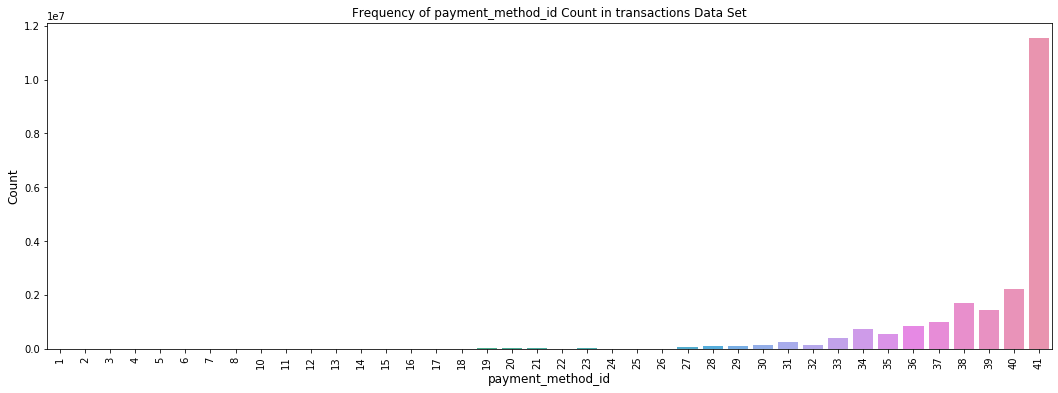

payment_method_id Count [(41, 11526454), (40, 2225283), (38, 1703590), (39, 1466655), (37, 1007689), (36, 855115), (34, 731539), (35, 541399), (33, 411164), (31, 252342), (30, 160957), (32, 146481), (29, 113885), (28, 95733), (27, 62525), (23, 42386), (19, 32073), (20, 28278), (21, 22883), (22, 20130), (24, 16196), (18, 16177), (25, 13780), (14, 13621), (16, 11064), (17, 7437), (13, 6571), (26, 4591), (12, 3834), (11, 2129), (15, 1479), (10, 1326), (7, 1094), (8, 657), (5, 474), (6, 466), (3, 210), (2, 52), (4, 15), (1, 12)]


In [30]:
plt.figure(figsize=(18,6))
#plt.subplot(311)
sns.countplot(x="payment_method_id", data=transactions)
plt.ylabel('Count', fontsize=12)
plt.xlabel('payment_method_id', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of payment_method_id Count in transactions Data Set", fontsize=12)
plt.show()
payment_method_id_count = Counter(transactions['payment_method_id']).most_common()
print("payment_method_id Count " +str(payment_method_id_count))

### payment_plan_days count

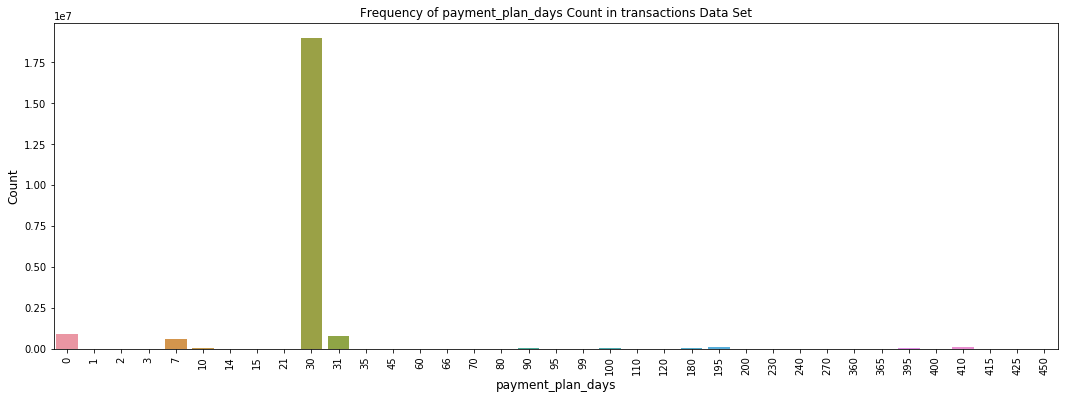

payment_plan_days Count [(30, 18956290), (0, 870124), (31, 766608), (7, 577639), (195, 110234), (410, 80139), (180, 52272), (10, 38216), (100, 24154), (90, 12310), (395, 10790), (120, 10007), (60, 7167), (14, 6365), (200, 5838), (360, 5486), (1, 4759), (400, 1856), (450, 1271), (240, 1088), (45, 1082), (21, 869), (35, 825), (70, 587), (80, 342), (99, 339), (365, 312), (270, 190), (66, 175), (110, 159), (230, 103), (2, 67), (3, 59), (15, 21), (425, 1), (415, 1), (95, 1)]


In [31]:

plt.figure(figsize=(18,6))
sns.countplot(x="payment_plan_days", data=transactions)
plt.ylabel('Count', fontsize=12)
plt.xlabel('payment_plan_days', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of payment_plan_days Count in transactions Data Set", fontsize=12)
plt.show()
payment_plan_days_count = Counter(transactions['payment_plan_days']).most_common()
print("payment_plan_days Count " +str(payment_plan_days_count))

### plan_list_price count

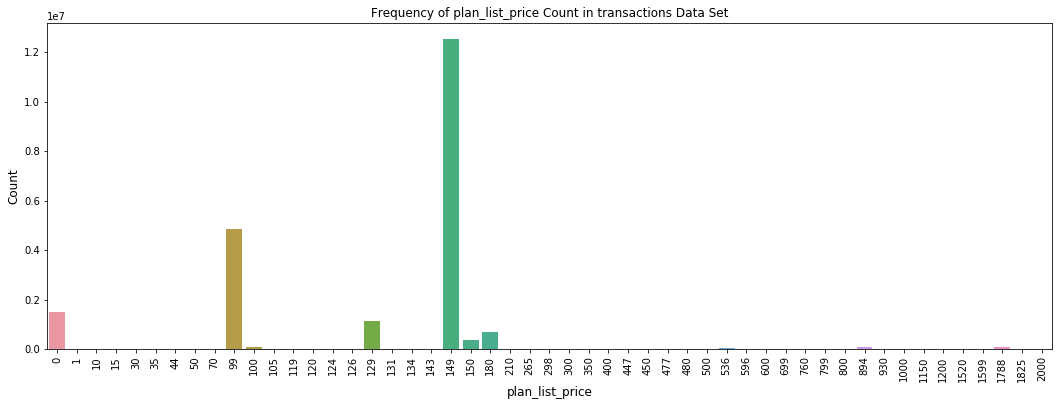

plan_list_price Count [(149, 12536656), (99, 4853433), (0, 1498544), (129, 1144459), (180, 682533), (150, 382860), (894, 109879), (100, 80285), (1788, 80066), (536, 43506), (119, 32280), (480, 22977), (1599, 11463), (477, 10847), (35, 7410), (799, 6264), (300, 5828), (120, 5821), (1200, 5486), (298, 5272), (930, 5082), (447, 4348), (134, 3743), (450, 1455), (500, 1185), (50, 1051), (699, 915), (1000, 750), (124, 598), (350, 587), (131, 374), (105, 348), (400, 342), (70, 250), (143, 143), (2000, 118), (1, 113), (1150, 103), (126, 99), (596, 70), (10, 67), (15, 50), (210, 26), (265, 21), (1520, 13), (800, 11), (30, 6), (760, 3), (600, 3), (1825, 2), (44, 1)]


In [32]:

plt.figure(figsize=(18,6))
sns.countplot(x="plan_list_price", data=transactions)
plt.ylabel('Count', fontsize=12)
plt.xlabel('plan_list_price', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of plan_list_price Count in transactions Data Set", fontsize=12)
plt.show()
plan_list_price_count = Counter(transactions['plan_list_price']).most_common()
print("plan_list_price Count " +str(plan_list_price_count))

### actual_amount_paid count

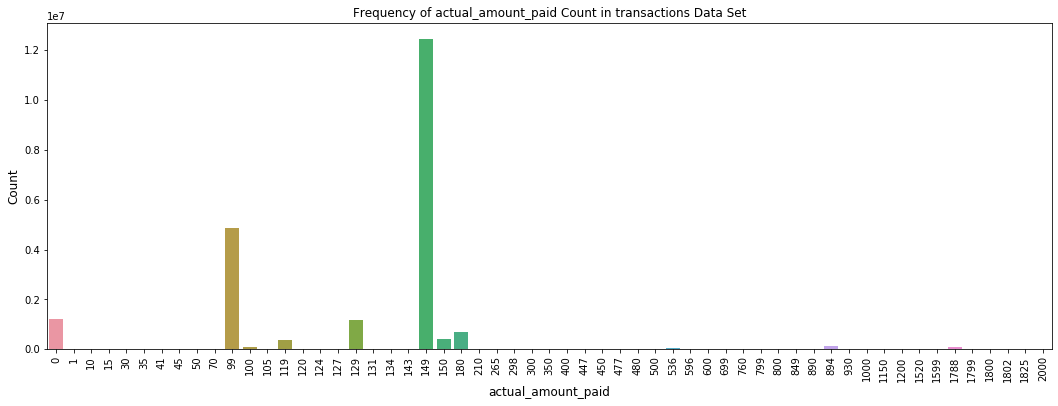

actual_amount_paid Count [(149, 12460832), (99, 4855208), (0, 1196876), (129, 1174670), (180, 680058), (150, 396210), (119, 355083), (894, 113452), (1788, 83991), (100, 80969), (536, 44805), (480, 23170), (1599, 12086), (477, 10847), (35, 7892), (799, 6465), (300, 5996), (1200, 5526), (298, 5272), (930, 5121), (120, 4948), (134, 4807), (447, 4375), (450, 1501), (500, 1211), (50, 1056), (699, 913), (1000, 783), (350, 606), (124, 598), (131, 572), (105, 374), (400, 351), (70, 250), (143, 143), (2000, 122), (1, 113), (1150, 105), (127, 99), (596, 76), (10, 67), (15, 50), (210, 26), (265, 21), (1520, 13), (800, 11), (30, 6), (41, 5), (760, 4), (600, 3), (1825, 2), (1799, 1), (890, 1), (1802, 1), (45, 1), (849, 1), (1800, 1)]


In [33]:

plt.figure(figsize=(18,6))
sns.countplot(x="actual_amount_paid", data=transactions)
plt.ylabel('Count', fontsize=12)
plt.xlabel('actual_amount_paid', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of actual_amount_paid Count in transactions Data Set", fontsize=12)
plt.show()
actual_amount_paid_count = Counter(transactions['actual_amount_paid']).most_common()
print("actual_amount_paid Count " +str(actual_amount_paid_count))

### is_auto_renew count

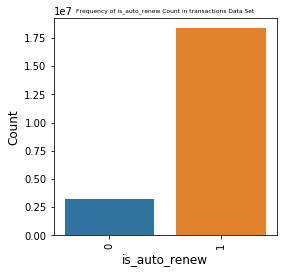

is_auto_renew Count [(1, 18357950), (0, 3189796)]


In [34]:

plt.figure(figsize=(4,4))
sns.countplot(x="is_auto_renew", data=transactions)
plt.ylabel('Count', fontsize=12)
plt.xlabel('is_auto_renew', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of is_auto_renew Count in transactions Data Set", fontsize=6)
plt.show()
is_auto_renew_count = Counter(transactions['is_auto_renew']).most_common()
print("is_auto_renew Count " +str(is_auto_renew_count))

### is_cancel count

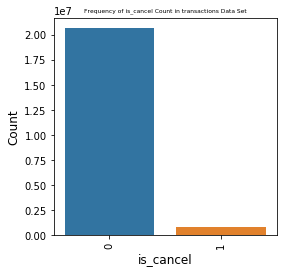

is_cancel Count [(0, 20690895), (1, 856851)]


In [35]:

plt.figure(figsize=(4,4))
sns.countplot(x="is_cancel", data=transactions)
plt.ylabel('Count', fontsize=12)
plt.xlabel('is_cancel', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of is_cancel Count in transactions Data Set", fontsize=6)
plt.show()
is_cancel_count = Counter(transactions['is_cancel']).most_common()
print("is_cancel Count " +str(is_cancel_count))

Observations :

- So there are 21 547 746 entries in transactions data set, as compared to 992 931 entries in training set ( about 5%)
- There are 40 payment methods( method class 9 is missing) and majority of users use payment method id 41
- There are 37 payment plan days, out of which 30 day plan is very frequent. This is quite understandable as most people will take monthly subscription
- There are 51 payment plan, out of which 149 one is most frequent.
- Amount paid also have same 51 types and 149 is the most frequent one. Also there is 93% correlation in Payment plan and Actual Amount Paid, so almost same. (see below for correlation)
- About 85% users have set their plan for Auto Renewal
- About 4% users have canceled the subscription during the plan period

In [36]:
#Correlation between plan_list_price and actual_amount_paid
transactions['plan_list_price'].corr(transactions['actual_amount_paid'],method='pearson') 

0.9349402313341029

Let us see whether msno(users ids) are unique in transaction data set.

In [37]:
#transactions['msno'].value_counts() 
(transactions['msno'].value_counts().reset_index())['msno'].value_counts()

1     592101
2     355938
26    120878
3     117118
4      82497
       ...  
46         1
59         1
58         1
55         1
71         1
Name: msno, Length: 61, dtype: int64

So there are also more than one entries of many users, maybe having different payment plans and different transaction period. 

<a id="5"></a> <br>
## Data Processing


To prepare the dataset for modeling churn, we need to encode categorical features to numbers. This means encoding "Yes", "No" to 0 and 1 so that algorithm can work with the data. This process is called onehot encoding.

But first of all, let's take all the available data to create ours models.

In [2]:
train = pd.read_csv('train_v2.csv',dtype={'is_churn':np.int8})
test = pd.read_csv('sample_submission_v2.csv',dtype={'is_churn':np.int8})
members = pd.read_csv('members_v3.csv',parse_dates=['registration_init_time'],dtype={'city':np.int8,'bd':np.int8,
                                                                                         'registered_via':np.int8})
transactions = pd.read_csv('transactions_v2.csv',parse_dates=['transaction_date','membership_expire_date'],
                          dtype={'payment_method_id':np.int8,'payment_plan_days':np.int8,'plan_list_price':np.int8,
                                'actual_amount_paid':np.int8,'is_auto_renew':np.int8,'is_cancel':np.int8})

user_log = pd.read_csv('user_logs_v2.csv',parse_dates=['date'],dtype={'num_25':np.int16,'num_50':np.int16,
                                    'num_75':np.int16,'num_985':np.int16,'num_100':np.int16,'num_unq':np.int16})

Let's merge all our database to create train and test :

In [3]:
train = pd.merge(train,members,on='msno',how='left')
test = pd.merge(test,members,on='msno',how='left')
train = pd.merge(train,transactions,how='left',on='msno',left_index=True, right_index=True)
test = pd.merge(test,transactions,how='left',on='msno',left_index=True, right_index=True,)
train = pd.merge(train,user_log,how='left',on='msno',left_index=True, right_index=True)
test = pd.merge(test,user_log,how='left',on='msno',left_index=True, right_index=True)

del members,transactions,user_log
print('Number of rows & columns',train.shape)
print('Number of rows & columns',test.shape)


Number of rows & columns (970960, 23)
Number of rows & columns (907471, 23)


Now, our data train has 970 960 rows and 23 columns and our data test has 907 471 rows and 23 columns.

In [43]:
train.head()

,msno,is_churn,city,bd,gender,registered_via,registration_init_time,payment_method_id,payment_plan_days,plan_list_price,...,membership_expire_date,is_cancel,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1,5.0,28.0,male,3.0,2013-12-23,32,90,42,...,2017-05-04,0,2017-03-31,8,4,0,1,21,18,6309.273
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1,13.0,20.0,male,3.0,2013-12-23,41,30,-107,...,2019-04-12,0,2017-03-30,2,2,1,0,9,11,2390.699
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1,13.0,18.0,male,3.0,2013-12-27,36,30,-76,...,2017-04-22,0,2017-03-31,52,3,5,3,84,110,23203.337
3,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,1,1.0,0.0,NaN,7.0,2014-01-09,36,30,-76,...,2017-03-31,1,2017-03-31,176,4,2,2,19,191,7100.454
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,1,13.0,35.0,female,7.0,2014-01-25,41,30,99,...,2017-04-23,0,2017-03-31,2,1,0,1,112,93,28401.558


In [44]:
test.head()

,msno,is_churn,city,bd,gender,registered_via,registration_init_time,payment_method_id,payment_plan_days,plan_list_price,...,membership_expire_date,is_cancel,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,4n+fXlyJvfQnTeKXTWT507Ll4JVYGrOC8LHCfwBmPE4=,0,1.0,0.0,NaN,7.0,2015-07-18,32,90,42,...,2017-05-04,0,2017-03-31,8,4,0,1,21,18,6309.273
1,aNmbC1GvFUxQyQUidCVmfbQ0YeCuwkPzEdQ0RwWyeZM=,0,4.0,28.0,male,9.0,2005-10-30,41,30,-107,...,2019-04-12,0,2017-03-30,2,2,1,0,9,11,2390.699
2,rFC9eSG/tMuzpre6cwcMLZHEYM89xY02qcz7HL4//jc=,0,4.0,34.0,male,7.0,2014-11-01,36,30,-76,...,2017-04-22,0,2017-03-31,52,3,5,3,84,110,23203.337
3,WZ59dLyrQcE7ft06MZ5dj40BnlYQY7PHgg/54+HaCSE=,0,NaN,NaN,NaN,NaN,NaT,36,30,-76,...,2017-03-31,1,2017-03-31,176,4,2,2,19,191,7100.454
4,aky/Iv8hMp1/V/yQHLtaVuEmmAxkB5GuasQZePJ7NU4=,0,1.0,0.0,NaN,13.0,2016-12-22,41,30,99,...,2017-04-23,0,2017-03-31,2,1,0,1,112,93,28401.558


Text(0.5, 0, 'The subscription within 30 days of expiration is True/False')

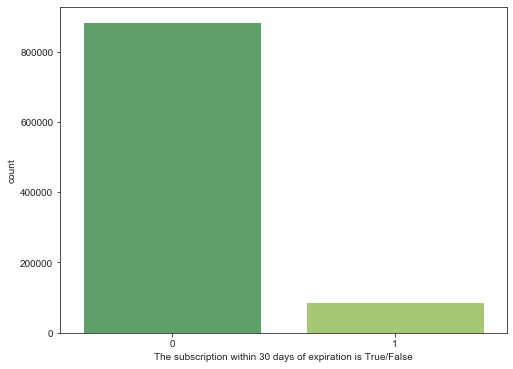

In [78]:
plt.figure(figsize=(8,6))
sns.set_style('ticks')
sns.countplot(train['is_churn'],palette='summer')
plt.xlabel('The subscription within 30 days of expiration is True/False')

Like I said earlier, our Y is very unbalanced !

### date feature

Let's check out all our date variable :

In [42]:
train[['registration_init_time' ,'transaction_date','membership_expire_date','date']].describe()

,registration_init_time,transaction_date,membership_expire_date,date
count,860967,970960,970960,970960
unique,4749,820,1818,31
top,2015-10-09 00:00:00,2017-03-31 00:00:00,2017-04-30 00:00:00,2017-03-30 00:00:00
freq,1575,130414,79283,32331
first,2004-03-26 00:00:00,2015-01-01 00:00:00,2016-04-20 00:00:00,2017-03-01 00:00:00
last,2017-04-24 00:00:00,2017-03-31 00:00:00,2036-10-15 00:00:00,2017-03-31 00:00:00


In [45]:
train[['registration_init_time' ,'transaction_date','membership_expire_date','date']].isnull().sum()

registration_init_time    109993
transaction_date               0
membership_expire_date         0
date                           0
dtype: int64

In [46]:
test[['registration_init_time' ,'transaction_date','membership_expire_date','date']].isnull().sum()


registration_init_time    112381
transaction_date               0
membership_expire_date         0
date                           0
dtype: int64

We see that registration_init_time have some missing values (NA) in both our train and test set. To deal with that, we will fill the missing values with the most commun date in registration_init_time. Above, we could see that the mos commun date is 2015-10-09 so let's do it ! 

In [4]:
train['registration_init_time'] = train['registration_init_time'].fillna(value=pd.to_datetime('09/10/2015'))
test['registration_init_time'] = test['registration_init_time'].fillna(value=pd.to_datetime('09/10/2015'))

Now let's change those variable so they could be used by machine learning packages. In the actual state (dd/mm/yy), that's quite difficult to interpret for the majority of the machine learning packages so we need to do some transformations :

In [5]:
def date_feature(df):
    
    col = ['registration_init_time' ,'transaction_date','membership_expire_date','date']
    var = ['reg','trans','mem_exp','user_']
    #df['duration'] = (df[col[1]] - df[col[0]]).dt.days 
    
    for i ,j in zip(col,var):
        df[j+'_day'] = df[i].dt.day.astype('uint8')
        df[j+'_weekday'] = df[i].dt.weekday.astype('uint8')        
        df[j+'_month'] = df[i].dt.month.astype('uint8') 
        df[j+'_year'] =df[i].dt.year.astype('uint16') 

date_feature(train)
date_feature(test)

In [49]:
train.head()

,msno,is_churn,city,bd,gender,registered_via,registration_init_time,payment_method_id,payment_plan_days,plan_list_price,...,trans_month,trans_year,mem_exp_day,mem_exp_weekday,mem_exp_month,mem_exp_year,user__day,user__weekday,user__month,user__year
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1,5.0,28.0,male,3.0,2013-12-23,32,90,42,...,1,2017,4,3,5,2017,31,4,3,2017
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1,13.0,20.0,male,3.0,2013-12-23,41,30,-107,...,8,2015,12,4,4,2019,30,3,3,2017
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1,13.0,18.0,male,3.0,2013-12-27,36,30,-76,...,3,2017,22,5,4,2017,31,4,3,2017
3,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,1,1.0,0.0,NaN,7.0,2014-01-09,36,30,-76,...,3,2017,31,4,3,2017,31,4,3,2017
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,1,13.0,35.0,female,7.0,2014-01-25,41,30,99,...,3,2017,23,6,4,2017,31,4,3,2017


Now, we can see that our date variables are integer with the day, the month and so on. Quite handy for machine learning packages !

On remplace les NA par les valeurs les plus présentes dans les variables suivantes :

In [6]:
col = [ 'city', 'bd', 'gender', 'registered_via']
def missing(df,columns):
    col = columns
    for i in col:
        df[i].fillna(df[i].mode()[0],inplace=True)
        
missing(train,col)
missing(test,col)

In [53]:
train.gender.value_counts()

male      786616
female    184344
Name: gender, dtype: int64

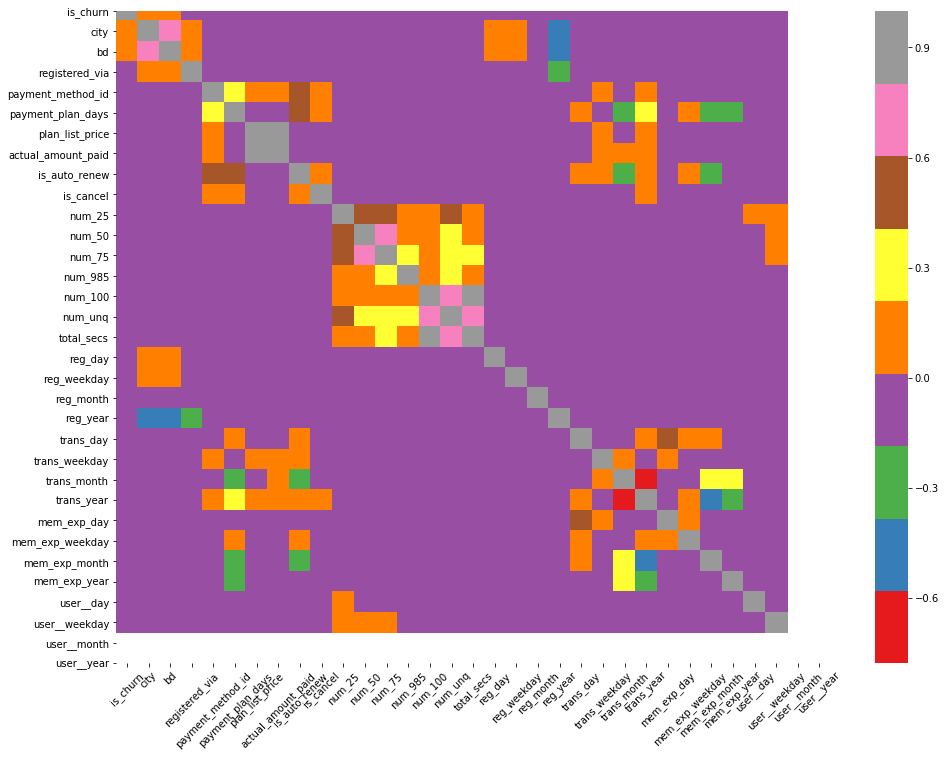

In [55]:
cor = train.corr()
plt.figure(figsize=(16,12))
sns.heatmap(cor,cmap='Set1',annot=False)
plt.xticks(rotation=45);

### Encoder

Let's encode our variable gender with LabelEncoder to obtain something more handy :

In [9]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train['gender'] = le.fit_transform(train['gender'])
test['gender'] = le.fit_transform(test['gender'])

## One hot encoding

This step aim to dummyfier our categorical variables like 'city', 'gender' or 'registered_via' :

In [10]:
def OHE(df):
    col = ['city','gender','registered_via']
    print('Categorical columns in dataset',col)
    
    c2,c3 = [],{}
    for c in col:
        if df[c].nunique()>2 :
            c2.append(c)
            c3[c] = 'ohe_'+c
    
    df = pd.get_dummies(df,columns=c2,drop_first=True,prefix=c3)
    print(df.shape)
    return df
train1 = OHE(train)
test1 = OHE(test)

Categorical columns in dataset ['city', 'gender', 'registered_via']
(970960, 61)
Categorical columns in dataset ['city', 'gender', 'registered_via']
(907471, 61)


Let's see all the variable in our train set :

In [58]:
train1.columns

Index(['msno', 'is_churn', 'bd', 'gender', 'registration_init_time',
       'payment_method_id', 'payment_plan_days', 'plan_list_price',
       'actual_amount_paid', 'is_auto_renew', 'transaction_date',
       'membership_expire_date', 'is_cancel', 'date', 'num_25', 'num_50',
       'num_75', 'num_985', 'num_100', 'num_unq', 'total_secs', 'reg_day',
       'reg_weekday', 'reg_month', 'reg_year', 'trans_day', 'trans_weekday',
       'trans_month', 'trans_year', 'mem_exp_day', 'mem_exp_weekday',
       'mem_exp_month', 'mem_exp_year', 'user__day', 'user__weekday',
       'user__month', 'user__year', 'ohe_city_3.0', 'ohe_city_4.0',
       'ohe_city_5.0', 'ohe_city_6.0', 'ohe_city_7.0', 'ohe_city_8.0',
       'ohe_city_9.0', 'ohe_city_10.0', 'ohe_city_11.0', 'ohe_city_12.0',
       'ohe_city_13.0', 'ohe_city_14.0', 'ohe_city_15.0', 'ohe_city_16.0',
       'ohe_city_17.0', 'ohe_city_18.0', 'ohe_city_19.0', 'ohe_city_20.0',
       'ohe_city_21.0', 'ohe_city_22.0', 'ohe_registered_via_4.0',
 

### Split our data sets :

In [11]:
unwanted = ['msno','is_churn','registration_init_time','transaction_date','membership_expire_date','date']

X = train1.drop(unwanted,axis=1)
y = train1['is_churn'].astype('category')
x_test = test1.drop(unwanted,axis=1)

<a id="6"></a> <br>
## Models selection :

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
import sklearn.model_selection as ms
from lightgbm import LGBMClassifier
import xgboost as xgb
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import StratifiedKFold

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression


from sklearn import tree
from sklearn import metrics
from sklearn import ensemble
from sklearn import linear_model 
from sklearn import naive_bayes 



KFold = StratifiedKFold(n_splits=3, random_state=42)
scores = {}

def score_model(model):
    return cross_val_score(model, X, y, scoring='roc_auc', cv = KFold)



# time: 10s
scores['tree'] = score_model(tree.DecisionTreeClassifier())

# time: 9s
scores['extra_tree'] = score_model(ensemble.ExtraTreesClassifier())

# time: 7s
scores['forest'] = score_model(ensemble.RandomForestClassifier())

# time: 33s
scores['ada_boost'] = score_model(ensemble.AdaBoostClassifier())

# time: 1min
scores['bagging'] = score_model(ensemble.BaggingClassifier())

# time: 2min30s
scores['grad_boost'] = score_model(ensemble.GradientBoostingClassifier())

# time: 49s
scores['ridge'] = score_model(linear_model.RidgeClassifier())

# time: 4s
scores['passive'] = score_model(linear_model.PassiveAggressiveClassifier())

# time: 4s
scores['sgd'] = score_model(linear_model.SGDClassifier())

# time: 3s
#scores['gaussian'] = score_model(naive_bayes.GaussianNB())

# time: 4min
scores['xgboost'] = score_model(xgb.XGBClassifier())

scores['LightGBM'] = score_model(LGBMClassifier())

scores['LinearSVC'] = score_model(LinearSVC())

scores['LR'] = score_model(LogisticRegression())

In [64]:
# Print the scores 
model_scores = pd.DataFrame(scores).mean()
model_scores = model_scores.sort_values(ascending=False)
print('Model scores\n{}'.format(model_scores))

Model scores
LightGBM      0.734912
grad_boost    0.729649
xgboost       0.729557
ada_boost     0.709765
forest        0.704892
extra_tree    0.698990
ridge         0.670319
LinearSVC     0.661067
bagging       0.639356
LR            0.608795
tree          0.537374
sgd           0.529860
passive       0.525195
dtype: float64


In [73]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=42)

LR = LogisticRegression(class_weight='balanced',C=1)


LR.fit(X_train, y_train)  # On entraîne le modèle sur le jeu de données train
predicted = LR.predict(X_test)



print(pd.crosstab(y_test, predicted, rownames=['Classe réelle'], colnames=['Classe prédite']))

print()
print()

print(classification_report(y_test, predicted))

print()
print()

print("score :", LR.score(X_test, y_test))

probs = LR.predict_proba(X_test)

fpr, tpr, seuils = roc_curve(y_test, probs[:,1])

roc_auc = auc(fpr, tpr)

print("courbe roc :", roc_auc)




C:\Users\slimh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Classe prédite       0      1
Classe réelle                
0               167217  97837
1                11547  14687


              precision    recall  f1-score   support

           0       0.94      0.63      0.75    265054
           1       0.13      0.56      0.21     26234

    accuracy                           0.62    291288
   macro avg       0.53      0.60      0.48    291288
weighted avg       0.86      0.62      0.70    291288



score : 0.624481612699459
courbe roc : 0.6055920018194609


Not great at all, I think we need to deal with this 'is_churn' unbalanced, so I will try oversampling :

<a id="7"></a> <br>
## OverSampling methods


In [12]:
from imblearn.over_sampling import (RandomOverSampler, 
                                    SMOTE, 
                                    ADASYN)

Using TensorFlow backend.


### RandomOverSampler

In [14]:
sampler = RandomOverSampler(random_state=12, sampling_strategy = 1.0)
X_rs, y_rs = sampler.fit_sample(X, y)

In [22]:
KFold = StratifiedKFold(n_splits=3, shuffle = True)

def score_model(model):
    return cross_validate(model, X_rs, y_rs, scoring='roc_auc', cv = KFold, return_train_score=True)

ScoreLightGBM = score_model(LGBMClassifier())

pd.DataFrame(ScoreLightGBM).mean()

fit_time       7.237614
score_time     1.290675
test_score     0.741993
train_score    0.743721
dtype: float64

That's seems a little better.

## SMOTE

In [24]:
sampler = SMOTE(random_state=12, sampling_strategy = 1.0)
X_rs, y_rs = sampler.fit_sample(X, y)

In [26]:
KFold = StratifiedKFold(n_splits=5, shuffle = True)

def score_model(model):
    return cross_validate(model, X_rs, y_rs, scoring='roc_auc', cv = KFold, return_train_score=True)

ScoreLightGBM = score_model(LGBMClassifier())

In [27]:
pd.DataFrame(ScoreLightGBM).mean()

fit_time       12.130068
score_time      1.261275
test_score      0.960914
train_score     0.961106
dtype: float64

Very nice ! SMOTE is always the one !

### Adasyn

In [28]:
sampler = ADASYN(random_state=12, sampling_strategy = 1.0)
X_rs, y_rs = sampler.fit_sample(X, y)

In [29]:
KFold = StratifiedKFold(n_splits=5, shuffle = True)

def score_model(model):
    return cross_validate(model, X_rs, y_rs, scoring='roc_auc', cv = KFold, return_train_score=True)

ScoreLightGBM = score_model(LGBMClassifier())

In [30]:
pd.DataFrame(ScoreLightGBM).mean()

fit_time       10.708433
score_time      1.118138
test_score      0.960110
train_score     0.960331
dtype: float64

Very nice too, but slightly less than smote.

<a id="8"></a> <br>
## Hyperparameter tuning

In [33]:
np.arange(500,1000,50)

array([300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900,
       950])

In [34]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth':np.arange(1,9), 'n_estimators': np.arange(500,1000,50), 'learning_rate' : np.arange(0.01, 0.1, 0.02)}
LGBM = LGBMClassifier()
clf = GridSearchCV(LGBM, parameters)
clf.fit(X_rs, y_rs)

GridSearchCV(cv=None, error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=None, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='deprecated', n_jobs=None,
             param_grid={'learning_rate': array([0.01, 0.03, 0.05, 0.07, 0.09]),
          

In [52]:
print('The best score obtained with GridSearchCV is {} with those parameters : {}'. format(clf.best_score_, clf.best_params_))

The best score obtained with GridSearchCV is 0.9339683297403576 with those parameters : {'learning_rate': 0.08999999999999998, 'max_depth': 8, 'n_estimators': 950}


In [41]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

X_train, X_test, y_train, y_test = train_test_split(X_rs, y_rs,test_size=0.3, random_state=42)

LR = LGBMClassifier(learning_rate= 0.08999999999999998, max_depth= 8, n_estimators=  950)


LR.fit(X_train, y_train)  # On entraîne le modèle sur le jeu de données train
predicted = LR.predict(X_test)



print(pd.crosstab(y_test, predicted, rownames=['Classe réelle'], colnames=['Classe prédite']))

print()
print()

print(classification_report(y_test, predicted))

print()
print()

print("score :", LR.score(X_test, y_test))

probs = LR.predict_proba(X_test)

fpr, tpr, seuils = roc_curve(y_test, probs[:,1])

roc_auc = auc(fpr, tpr)

print("courbe roc :", roc_auc)

Classe prédite       0       1
Classe réelle                 
0               261237    4045
1                29740  231262


              precision    recall  f1-score   support

           0       0.90      0.98      0.94    265282
           1       0.98      0.89      0.93    261002

    accuracy                           0.94    526284
   macro avg       0.94      0.94      0.94    526284
weighted avg       0.94      0.94      0.94    526284



score : 0.9358046225992049
courbe roc : 0.9662816688259053


Very nice !

<a id="9"></a> <br>
## First submit to Kaggle

In [44]:
LGBM = LGBMClassifier(learning_rate= 0.08999999999999998, max_depth= 8, n_estimators=  950)
LGBM.fit(X,y)
y_pred = LGBM.predict_proba(x_test)[:,1]
LGBM.score(X,y)

0.9113413528878636

In [45]:
submit = pd.DataFrame({'msno':test['msno'],'is_churn':y_pred})
submit.to_csv('LGBM_pred.csv',index=False)

0,15882

In [46]:
LGBM = LGBMClassifier()
LGBM.fit(X,y)
y_pred = LGBM.predict_proba(x_test)[:,1]
LGBM.score(X,y)

0.9104906484304194

In [47]:
submit = pd.DataFrame({'msno':test['msno'],'is_churn':y_pred})
submit.to_csv('LGBM_pred2.csv',index=False)

0,15824

The hyperparameters tuning wasn't necessary after all. We can see that the result are almost identical, with and without the paramaters obtained with GridSearchCV. I had to try, just for good measures.

<a id="10"></a> <br>
## Feature Engineering

"Feature Engineering is an art". Someone once said to spend more time on deriving more and meaningful features.But infomation fed to the model must make sense in whatever form it is given. Creating loads of features having no sense is of no use at all.

Let's try adding some feature to our models. Those feature will be created from feature previously here. 

I'll start over my process, in order to have a clear mind.
Let's load the data :

In [33]:
train = pd.read_csv('train_v2.csv',dtype={'is_churn':np.int8})
test = pd.read_csv('sample_submission_v2.csv',dtype={'is_churn':np.int8})
members = pd.read_csv('members_v3.csv',parse_dates=['registration_init_time'],dtype={'city':np.int8,'bd':np.int8,
                                                                                         'registered_via':np.int8})
transactions = pd.read_csv('transactions_v2.csv',parse_dates=['transaction_date','membership_expire_date'],
                          dtype={'payment_method_id':np.int8,'payment_plan_days':np.int8,'plan_list_price':np.int8,
                                'actual_amount_paid':np.int8,'is_auto_renew':np.int8,'is_cancel':np.int8})

user_log = pd.read_csv('user_logs_v2.csv',parse_dates=['date'],dtype={'num_25':np.int16,'num_50':np.int16,
                                    'num_75':np.int16,'num_985':np.int16,'num_100':np.int16,'num_unq':np.int16})

Let's get started !

### Feature 1 : discount
We can create a discount column to see how much discount was offered to the customer.

In [34]:
transactions['discount'] = transactions['plan_list_price'] - transactions['actual_amount_paid']

transactions['discount'].unique()

array([   0,  -76,   30,  107, -107,   50, -119,   20,   99,   45,   -1,
        127,  -84, -127,  120,    4, -100,   80,   65,    1,   63,   10,
          8,  -90,   -3, -126,  126], dtype=int64)

### Feature 2 : is_discount¶
Let us create another column is_column to check whether the customer has availed any discount or not.

In [35]:
transactions['is_discount'] = transactions.discount.apply(lambda x: 1 if x > 0 else 0)
print(transactions['is_discount'].head())
print(transactions['is_discount'].unique())

0    0
1    0
2    0
3    0
4    0
Name: is_discount, dtype: int64
[0 1]


### Feature 3 : amount_per_day
A new column featuring amount per-day can be added.

In [36]:
transactions['amt_per_day'] = transactions['actual_amount_paid'] / transactions['payment_plan_days']
transactions['amt_per_day'].head()

0    0.466667
1   -3.566667
2   -2.533333
3   -2.533333
4    3.300000
Name: amt_per_day, dtype: float64

### Feature 4 : membership_duration
The difference between transaction_date and membership_expire_date would give us membership duration.

In [37]:
transactions['membership_duration'] = transactions.membership_expire_date - transactions.transaction_date
transactions['membership_duration'] = transactions['membership_duration'] / np.timedelta64(1, 'D')
transactions['membership_duration'] = transactions['membership_duration'].astype(int)


Let's merge train, members and transactions :

In [38]:
train = pd.merge(train,members,on='msno',how='left')
test = pd.merge(test,members,on='msno',how='left')
train = pd.merge(train,transactions,how='left',on='msno',left_index=True, right_index=True)
test = pd.merge(test,transactions,how='left',on='msno',left_index=True, right_index=True,)

### Feature 5 : autorenew_&_not_cancel
A binary feature to see whether mebers have auto renewed and not cancelled at the same time:

 - auto_renew = 1 and
 - is_cancel = 0

In [39]:
train['autorenew_&_not_cancel'] = ((train.is_auto_renew == 1) == (train.is_cancel == 0)).astype(np.int8)
train['autorenew_&_not_cancel'].unique()

array([0, 1], dtype=int64)

In [40]:
test['autorenew_&_not_cancel'] = ((test.is_auto_renew == 1) == (test.is_cancel == 0)).astype(np.int8)
test['autorenew_&_not_cancel'].unique()

array([0, 1], dtype=int64)

### Feature 6 : notAutorenew_&_cancel
Binary feature to predict possible churning if

- auto_renew = 0 and
- is_cancel = 1

In [41]:
train['notAutorenew_&_cancel'] = ((train.is_auto_renew == 0) == (train.is_cancel == 1)).astype(np.int8)
train['notAutorenew_&_cancel'].unique()

array([0, 1], dtype=int64)

In [42]:
test['notAutorenew_&_cancel'] = ((test.is_auto_renew == 0) == (test.is_cancel == 1)).astype(np.int8)
test['notAutorenew_&_cancel'].unique()

array([0, 1], dtype=int64)

Now, we'll merge with user_log to have a complete database for our modelling.

In [43]:
train = pd.merge(train,user_log,how='left',on='msno',left_index=True, right_index=True)
test = pd.merge(test,user_log,how='left',on='msno',left_index=True, right_index=True)

Let's remake our data processing.

In [44]:
train['registration_init_time'] = train['registration_init_time'].fillna(value=pd.to_datetime('09/10/2015'))
test['registration_init_time'] = test['registration_init_time'].fillna(value=pd.to_datetime('09/10/2015'))

In [45]:
def date_feature(df):
    
    col = ['registration_init_time' ,'transaction_date','membership_expire_date','date']
    var = ['reg','trans','mem_exp','user_']
    #df['duration'] = (df[col[1]] - df[col[0]]).dt.days 
    
    for i ,j in zip(col,var):
        df[j+'_day'] = df[i].dt.day.astype('uint8')
        df[j+'_weekday'] = df[i].dt.weekday.astype('uint8')        
        df[j+'_month'] = df[i].dt.month.astype('uint8') 
        df[j+'_year'] =df[i].dt.year.astype('uint16') 

date_feature(train)
date_feature(test)

In [46]:
col = [ 'city', 'bd', 'gender', 'registered_via', 'amt_per_day']
def missing(df,columns):
    col = columns
    for i in col:
        df[i].fillna(df[i].mode()[0],inplace=True)
        
missing(train,col)
missing(test,col)

In [47]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train['gender'] = le.fit_transform(train['gender'])
test['gender'] = le.fit_transform(test['gender'])

In [48]:
def OHE(df):
    col = ['city','gender','registered_via']
    print('Categorical columns in dataset',col)
    
    c2,c3 = [],{}
    for c in col:
        if df[c].nunique()>2 :
            c2.append(c)
            c3[c] = 'ohe_'+c
    
    df = pd.get_dummies(df,columns=c2,drop_first=True,prefix=c3)
    print(df.shape)
    return df
train1 = OHE(train)
test1 = OHE(test)

Categorical columns in dataset ['city', 'gender', 'registered_via']
(970960, 67)
Categorical columns in dataset ['city', 'gender', 'registered_via']
(907471, 67)


In [49]:
# train1 =train1[~train.isin([np.nan, np.inf, -np.inf]).any(1)]

In [63]:
unwanted = ['msno','is_churn','registration_init_time','transaction_date','membership_expire_date','date']
unwanted2 = ['is_churn','registration_init_time','transaction_date','membership_expire_date','date']

X = train1.drop(unwanted,axis=1)
y = train1['is_churn'].astype('category')
x_test = test1.drop(unwanted2,axis=1)

Like earlier, I will use SMOTE

In [24]:
from imblearn.over_sampling import (RandomOverSampler, 
                                    SMOTE, 
                                    ADASYN)

Using TensorFlow backend.


In [64]:
sampler = SMOTE(random_state=12, sampling_strategy = 1.0)
X_rs, y_rs = sampler.fit_sample(X, y)

<a id="11"></a> <br>
## Model selection

Because of all our modifications, it's better to relauch our models selection. To see if LightGBM is our best model again.

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
import sklearn.model_selection as ms
from lightgbm import LGBMClassifier
import xgboost as xgb
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import StratifiedKFold

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression


from sklearn import tree
from sklearn import metrics
from sklearn import ensemble
from sklearn import linear_model 
from sklearn import naive_bayes 



KFold = StratifiedKFold(n_splits=3, shuffle = True)
scores = {}

def score_model(model):
    return cross_val_score(model, X_rs, y_rs, scoring='roc_auc', cv = KFold)



# time: 10s
scores['tree'] = score_model(tree.DecisionTreeClassifier())

# time: 9s
scores['extra_tree'] = score_model(ensemble.ExtraTreesClassifier())

# time: 7s
scores['forest'] = score_model(ensemble.RandomForestClassifier())

# time: 33s
scores['ada_boost'] = score_model(ensemble.AdaBoostClassifier())

# time: 1min
scores['bagging'] = score_model(ensemble.BaggingClassifier())

# time: 2min30s
scores['grad_boost'] = score_model(ensemble.GradientBoostingClassifier())

# time: 49s
scores['ridge'] = score_model(linear_model.RidgeClassifier())

# time: 4s
scores['passive'] = score_model(linear_model.PassiveAggressiveClassifier())

# time: 4s
scores['sgd'] = score_model(linear_model.SGDClassifier())

# time: 3s
#scores['gaussian'] = score_model(naive_bayes.GaussianNB())

# time: 4min
scores['xgboost'] = score_model(xgb.XGBClassifier())

scores['LightGBM'] = score_model(LGBMClassifier())

scores['LinearSVC'] = score_model(LinearSVC())

scores['LR'] = score_model(LogisticRegression())

In [55]:
# Print the scores 
model_scores = pd.DataFrame(scores).mean()
model_scores = model_scores.sort_values(ascending=False)
print('Model scores\n{}'.format(model_scores))

Model scores
forest        0.969058
extra_tree    0.968824
LightGBM      0.961582
bagging       0.956328
xgboost       0.928081
grad_boost    0.927092
ada_boost     0.926491
ridge         0.911419
tree          0.871226
LinearSVC     0.836330
passive       0.757302
sgd           0.696927
LR            0.630384
dtype: float64


Random Forest beats slightly LightGBM, let's use it.

In [57]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

X_train, X_test, y_train, y_test = train_test_split(X_rs, y_rs,test_size=0.3, random_state=42)

LR = RandomForestClassifier()


LR.fit(X_train, y_train)  # On entraîne le modèle sur le jeu de données train
predicted = LR.predict(X_test)



print(pd.crosstab(y_test, predicted, rownames=['Classe réelle'], colnames=['Classe prédite']))

print()
print()

print(classification_report(y_test, predicted))

print()
print()

print("score :", LR.score(X_test, y_test))

probs = LR.predict_proba(X_test)

fpr, tpr, seuils = roc_curve(y_test, probs[:,1])

roc_auc = auc(fpr, tpr)

print("courbe roc :", roc_auc)


Classe prédite       0       1
Classe réelle                 
0               259032    5442
1                31389  233521


              precision    recall  f1-score   support

           0       0.89      0.98      0.93    264474
           1       0.98      0.88      0.93    264910

    accuracy                           0.93    529384
   macro avg       0.93      0.93      0.93    529384
weighted avg       0.93      0.93      0.93    529384



score : 0.930426684599459
courbe roc : 0.9694454056885595


Very nice result. Modalities 0 and 1 are wery well predicted despite the unbalanced data, thanks to SMOTE !

<a id="12"></a> <br>
## Second submit to Kaggle

In [60]:
#x_test =x_test[~x_test.isin([np.nan, np.inf, -np.inf]).any(1)]

clf = RandomForestClassifier()
clf.fit(X_rs,y_rs)
y_pred = clf.predict_proba(x_test)[:,1]
clf.score(X,y)

0.9999907168356374

In [74]:
unwanted = ['msno','is_churn','registration_init_time','transaction_date','membership_expire_date','date']
unwanted2 = ['is_churn','registration_init_time','transaction_date','membership_expire_date','date']

X = train1.drop(unwanted,axis=1)
y = train1['is_churn'].astype('category')
x_test = test1.drop(unwanted,axis=1)

x_test =x_test[~x_test.isin([np.nan, np.inf, -np.inf]).any(1)]

y_pred = clf.predict_proba(x_test)[:,1]

In [75]:
#test1 =test1[~test1.isin([np.nan, np.inf, -np.inf]).any(1)]

submit = pd.DataFrame({'msno':test1['msno'],'is_churn':y_pred})
submit.to_csv('RF_pred.csv',index=False)

0.13689 ! That's better, nice ! Our feature engineering is relevant. 